In [2]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [9]:
files = glob.glob('../../../Data_Thesis/Iron/WC_FeT_Rerun/GOM21FA_2148_2149_2150_2151_2152_CAL_CURVE/*nm*.txt')
files

#here is where the output will go 
path2 = '../../../Data_Thesis/Iron/WC_FeT_Rerun/CAL_CURVE_6.2.2023.csv'
files

['../../../Data_Thesis/Iron/WC_FeT_Rerun/GOM21FA_2148_2149_2150_2151_2152_CAL_CURVE\\000_nm_post_Absorbance_01.txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/GOM21FA_2148_2149_2150_2151_2152_CAL_CURVE\\000_nm_post_Absorbance_02.txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/GOM21FA_2148_2149_2150_2151_2152_CAL_CURVE\\000_nm_pre_Absorbance_11-53-25-495.txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/GOM21FA_2148_2149_2150_2151_2152_CAL_CURVE\\000_nm_pre_Absorbance_11-53-36-457.txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/GOM21FA_2148_2149_2150_2151_2152_CAL_CURVE\\000_nm_pre_Absorbance_11-53-54-451.txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/GOM21FA_2148_2149_2150_2151_2152_CAL_CURVE\\010_nm_post_Absorbance_01.txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/GOM21FA_2148_2149_2150_2151_2152_CAL_CURVE\\010_nm_pre_Absorbance_11-55-28-346.txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/GOM21FA_2148_2149_2150_2151_2152_CAL_CURVE\\010_nm_pre_Absorbance_11-55-50-268.txt',
 '../../../Data_The

In [10]:
def GET_DATA(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']
    #df['wl'] = df['wl']
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [11]:
frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index
df

,000_nm_post_Absorbance_01.txt,000_nm_post_Absorbance_02.txt,000_nm_pre_Absorbance_11-53-25-495.txt,000_nm_pre_Absorbance_11-53-36-457.txt,000_nm_pre_Absorbance_11-53-54-451.txt,010_nm_post_Absorbance_01.txt,010_nm_pre_Absorbance_11-55-28-346.txt,010_nm_pre_Absorbance_11-55-50-268.txt,020_nm_post_Absorbance_01.txt,020_nm_post_Absorbance_02.txt,...,050_nm_pre_Absorbance_11-57-58-170.txt,050_nm_pre_Absorbance_11-58-24-912.txt,100_nm_post_Absorbance_01.txt,100_nm_pre_Absorbance_11-59-06-413.txt,100_nm_pre_Absorbance_11-59-17-078.txt,200_nm_post_Absorbance_01.txt,200_nm_post_Absorbance_02.txt,200_nm_post_Absorbance_03.txt,200_nm_pre_Absorbance_12-01-40-305.txt,wl
wl,,,,,,,,,,,,,,,,,,,,,
189,0.011799,0.011317,-4.928415,0.009751,-1.992584,0.011275,-7.209731,-10.145601,-2.654243,0.480183,...,1.725162,-6.565278,-3.508010,-3.069191,-14.214494,-1.057950,3.643426,0.015223,-11.215803,189
190,0.011799,0.011317,-0.097942,0.009751,-0.024380,0.011275,-0.127724,-0.178657,-0.040045,0.019299,...,-0.112403,-0.111635,-0.070264,-0.137335,-0.386787,-0.128746,-0.030236,0.015223,-0.208407,190
191,0.010749,0.180719,0.049923,0.009751,-0.253414,0.025525,0.009085,0.051083,0.010456,0.381087,...,-0.078545,-0.156073,-0.288785,0.403065,-0.235871,0.139040,0.177951,0.261823,-0.028151,191
192,-1.004214,-0.031675,-0.042064,-0.444478,-0.007995,-0.030102,-0.018217,-1.095442,-0.896958,-0.027725,...,-0.804503,-0.843038,-0.860558,-0.649158,0.497006,-0.064711,-0.931921,-0.024727,-0.007751,192
193,0.154476,-0.467576,0.090525,-0.256788,-0.256910,-0.044196,0.072444,0.013883,0.383082,0.046702,...,0.355120,0.086473,0.209741,-0.011385,0.292743,0.193094,-0.033999,0.133161,-0.007751,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.025262,0.061545,0.055340,0.049809,0.038698,0.034184,0.024946,0.046822,0.034229,0.045585,...,0.034149,0.051367,0.024591,0.095586,0.052332,0.072225,0.041469,0.082075,0.064545,876
877,0.023575,0.042063,0.019550,0.016144,0.028355,0.022682,0.020311,0.019353,0.034162,-0.007293,...,0.007840,0.045407,0.051417,0.059204,0.050219,0.048444,0.036717,0.059800,0.044063,877
878,0.006575,-0.006369,0.013936,0.042002,0.015570,0.014946,0.014046,0.042235,0.015149,0.029548,...,0.016680,0.034441,0.045276,0.022778,0.025226,0.018004,0.027972,0.065900,0.036674,878


In [12]:
#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
#edit here to make the names a 6 diget number code 
names = d.columns.str.rsplit('_', n=7).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df['wl'] = df.index
df

,000,010,020,050,100,200,wl
wl,,,,,,,
189,-1.377626,-5.781352,-1.434248,-3.165591,-6.930565,-2.153776,189
190,-0.017891,-0.098369,-0.040513,-0.098481,-0.198129,-0.088042,190
191,-0.000454,0.028564,0.135411,-0.083859,-0.040530,0.137666,191
192,-0.306085,-0.381254,-0.276402,-0.884026,-0.337570,-0.257277,192
193,-0.147255,0.014044,0.137368,0.080023,0.163700,0.071126,193
...,...,...,...,...,...,...,...
876,0.046131,0.035318,0.048462,0.041328,0.057503,0.065078,876
877,0.025937,0.020782,0.029719,0.036379,0.053613,0.047256,877
878,0.014343,0.023743,0.031457,0.023156,0.031093,0.037137,878


Text(0.5, 1.0, 'BC_ABS_BLU22_2226_GB')

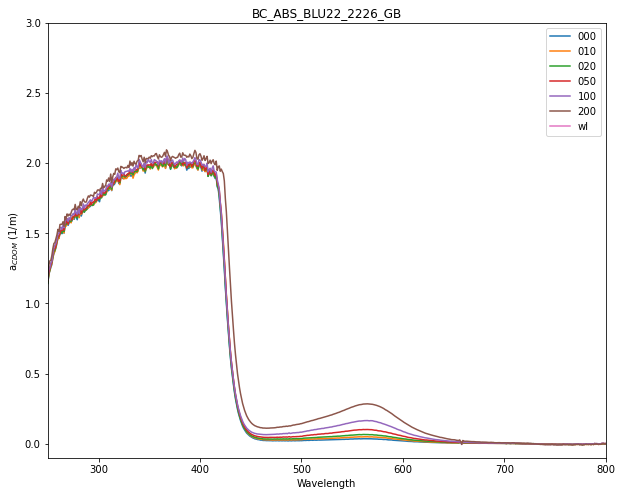

In [13]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("BC_ABS_BLU22_2226_GB")


In [14]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    
    abs_562 = df[(df['wl']==562)][col].mean()
    
    ydata = df[(df['wl']>=450) & (df['wl']<=700)][col]
    xdata = df[(df['wl']>=450) & (df['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')
ss_outs.to_csv(path2)

ss_outs['conc'] = ss_outs.index.astype(int)
ss_outs

,abs_562,intagration,conc
sample,,,
000,0.035957,4.965345,0
010,0.049885,6.564659,10
020,0.065812,8.434618,20
050,0.101135,12.274807,50
100,0.164911,19.094885,100
200,0.283688,33.078253,200


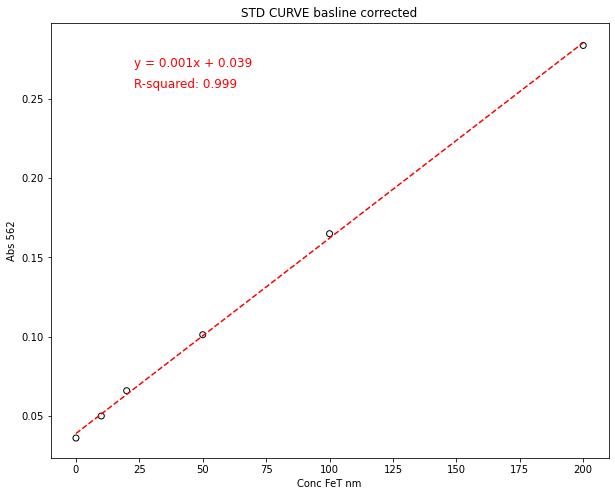

In [15]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(ss_outs['conc'], ss_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = ss_outs['conc']
y = ss_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()


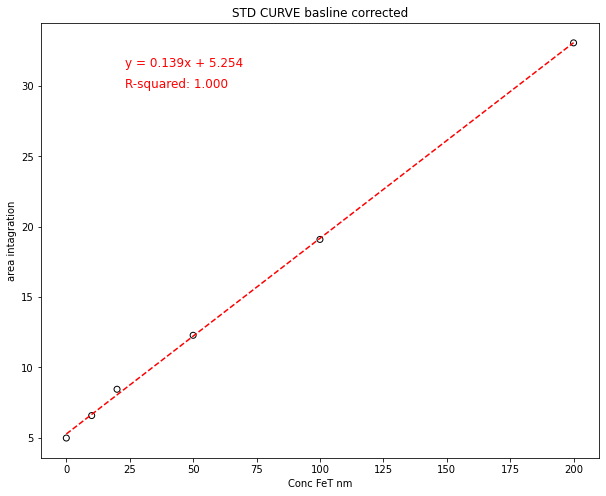

In [16]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(ss_outs['conc'], ss_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = ss_outs['conc']
y = ss_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()

EXPERIMENTAL